<a href="https://colab.research.google.com/github/miraclehimself/Advanced_ML/blob/main/pdp_ice_diabetes_week6b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML 22-23 S2W6 PDP/ICE Webinar: Classification, Diabetes

Key Points:

*


## Packages

In [ ]:
!pip install --upgrade scikit-learn category_encoders -q --user
# need to restart kernel, if latest versions not already installed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks',
    context='talk',
    font_scale=0.8,
    rc={'figure.figsize': (8,6)}
)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 17.4 MB/s eta 0:00:00


## Diabetes Dataset

In [ ]:
diabetes = pd.read_csv(
    'https://raw.githubusercontent.com/gerberl/6G7V0017_2223/main/datasets/diabetes.csv'
)

In [ ]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X, y = diabetes.drop(columns='Outcome'), diabetes['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

### Pre-Processing and Model Fitting Pipelines

In [ ]:
# Homework for you:
# the missing data is represented by 0...
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
).set_output(transform='pandas')

In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
    ]
).set_output(transform='pandas')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [ ]:
clf_model = RandomForestClassifier(
    max_depth=8, min_samples_split=15, min_samples_leaf=8, n_estimators=400
)
# clf_model = HistGradientBoostingRegressor(
#     max_depth=8, max_iter=400
# )

In [ ]:
clf_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", clf_model)
    ]
).set_output(transform="pandas")

In [ ]:
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('clf',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=8,
                                        min_samples_split=15,
                                        n_estimators=400))])

In [ ]:
# by the default, score of a classification model is the ordinary accuracy
# number of correct predictions / number of observations
clf_pipe.score(X_test, y_test)

0.7916666666666666

In [ ]:
scores = cross_val_score(
    clf_pipe, X_train, y_train, cv=10, scoring='balanced_accuracy'
)
scores.mean(), scores.std()

(0.7187065637065638, 0.06561673102127477)

### SHAP Local and Global Explainability

In [ ]:
explainer = shap.TreeExplainer(clf_pipe['clf'])

In [ ]:
shap_values = explainer.shap_values(
    clf_pipe['preprocessor'].transform(X)
)
feature_names = clf_pipe['preprocessor'].transform(X).columns

In [ ]:
clf_pipe.predict(X.head(1))

array([1])

In [ ]:
X.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50


In [ ]:
y.unique()

array([1, 0])

In [ ]:
clf_pipe['clf'].classes_

array([0, 1])

In [ ]:
clf_pipe.predict_proba(X.head(1))

array([[0.29043421, 0.70956579]])

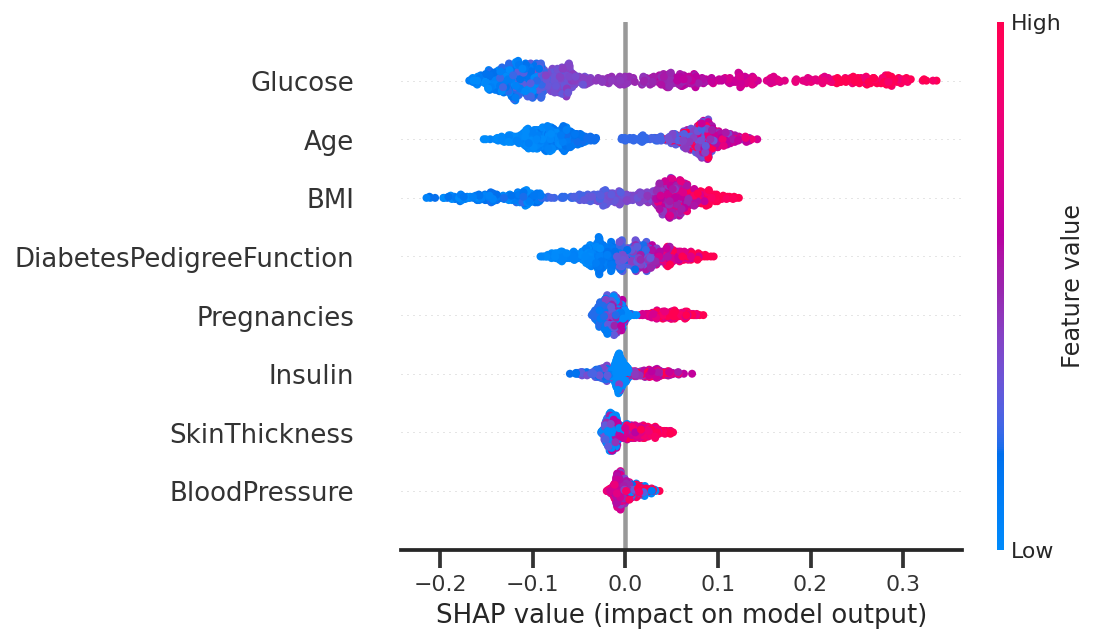

In [ ]:
shap.summary_plot(
    # I need to specify the class...
    shap_values[1],
    clf_pipe['preprocessor'].transform(X)
)

In [ ]:
# the feature/SHAP value impact on the outcome
# for some reason, force_plot needs the Javascript to be initialised in each cell...
shap.initjs()
# a local explanation with force_plot
# (class value 1 is `yes` for onset of diabetes; row index is refers to
# an observation to analyse
cls_idx = 1
row_idx = 0
shap.force_plot(
    explainer.expected_value[cls_idx],
    shap_values[cls_idx][row_idx],
    features=feature_names
)

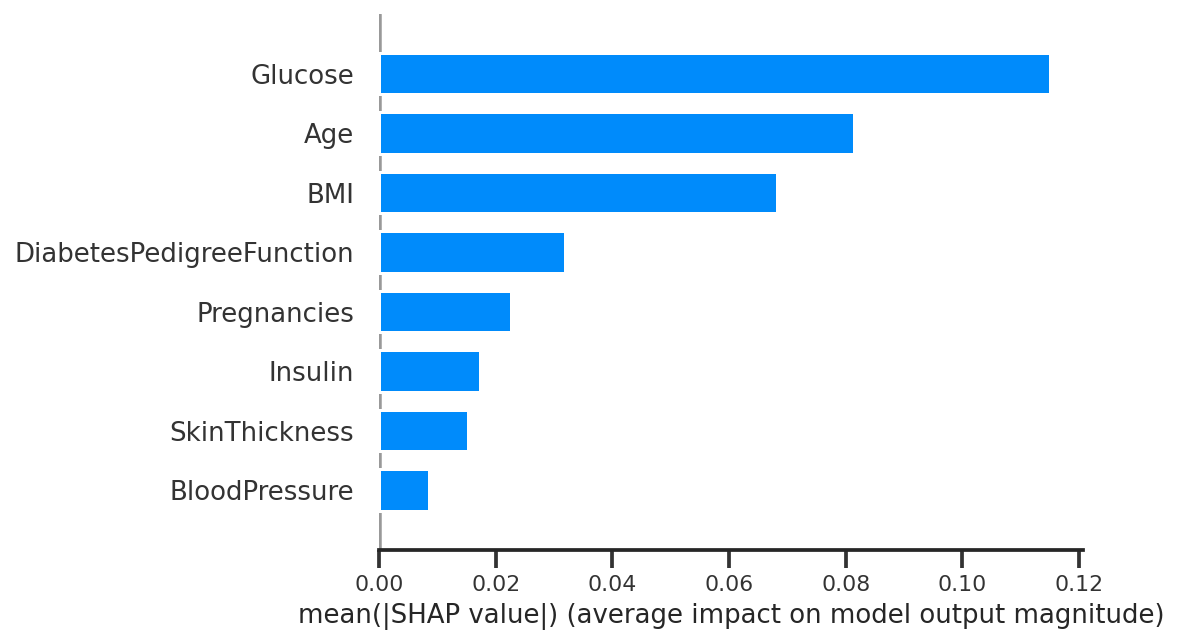

In [ ]:
shap.summary_plot(
    shap_values[1], feature_names, plot_type="bar"
)

## PDP/ICE

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

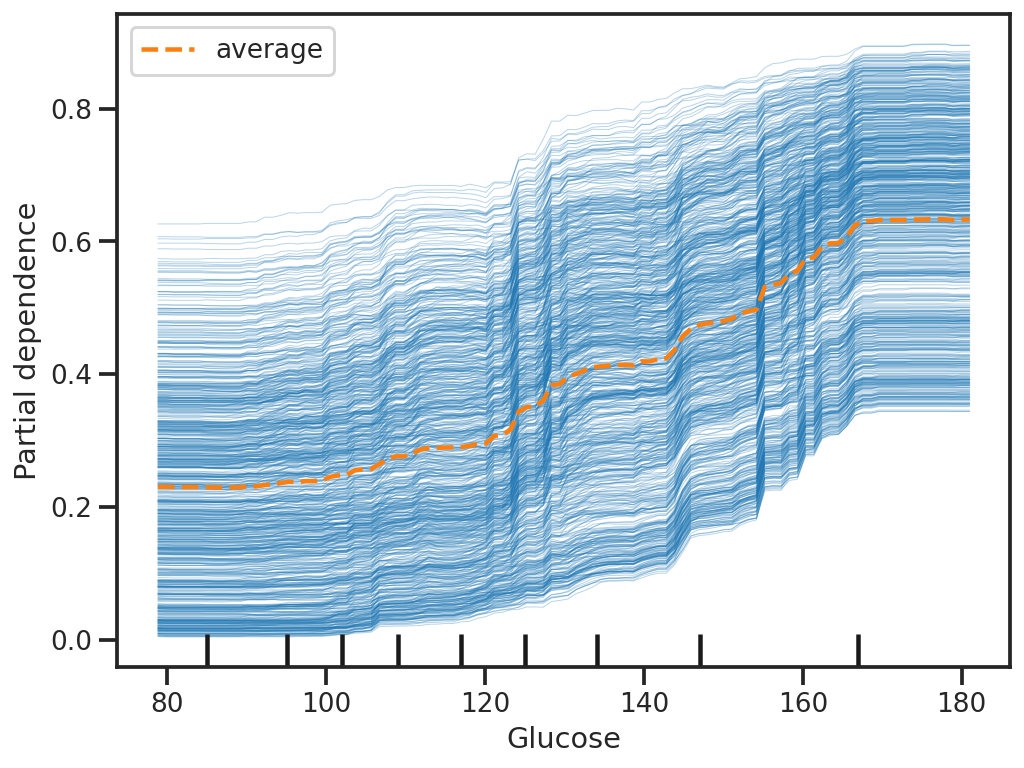

In [ ]:
PartialDependenceDisplay.from_estimator(
    clf_pipe, X, features=['Glucose'], kind='both'
);

In [ ]:
X.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50


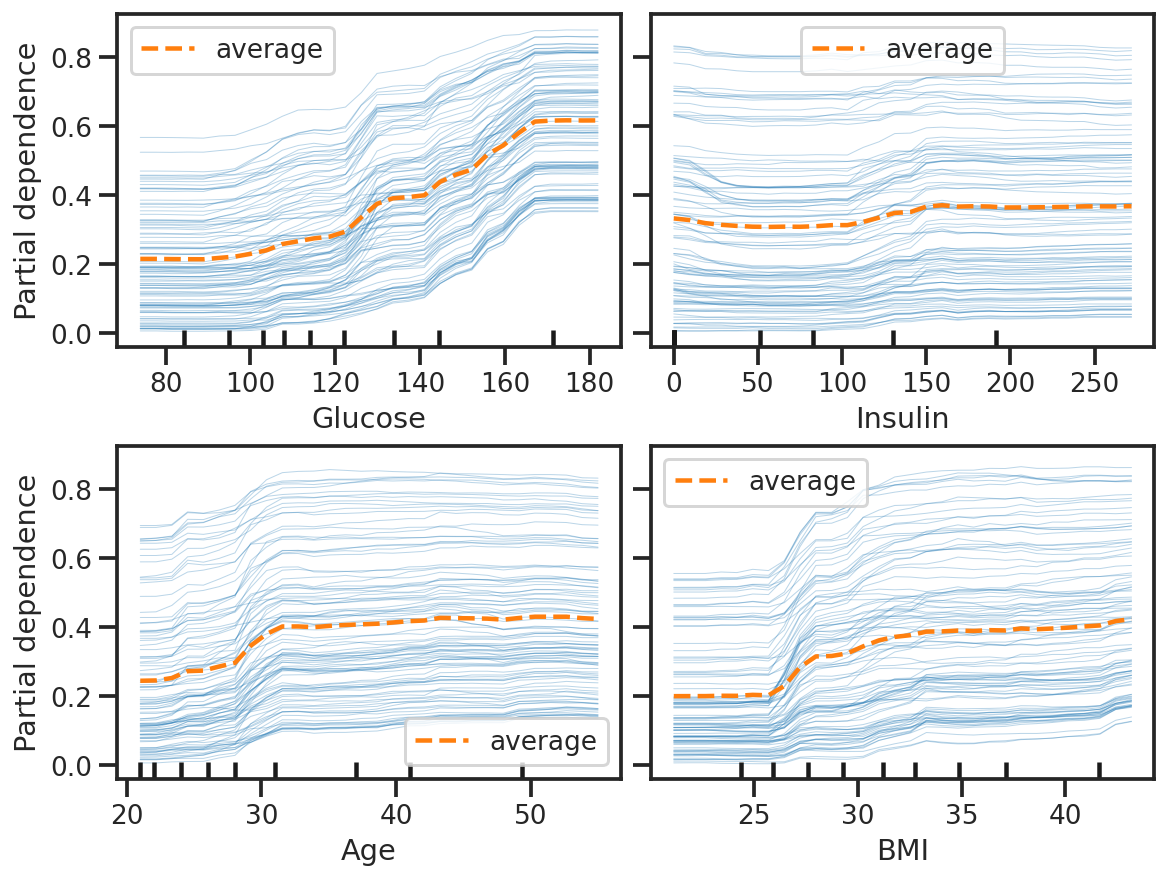

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    clf_pipe, X_test, features=['Glucose', 'Insulin', 'Age', 'BMI'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

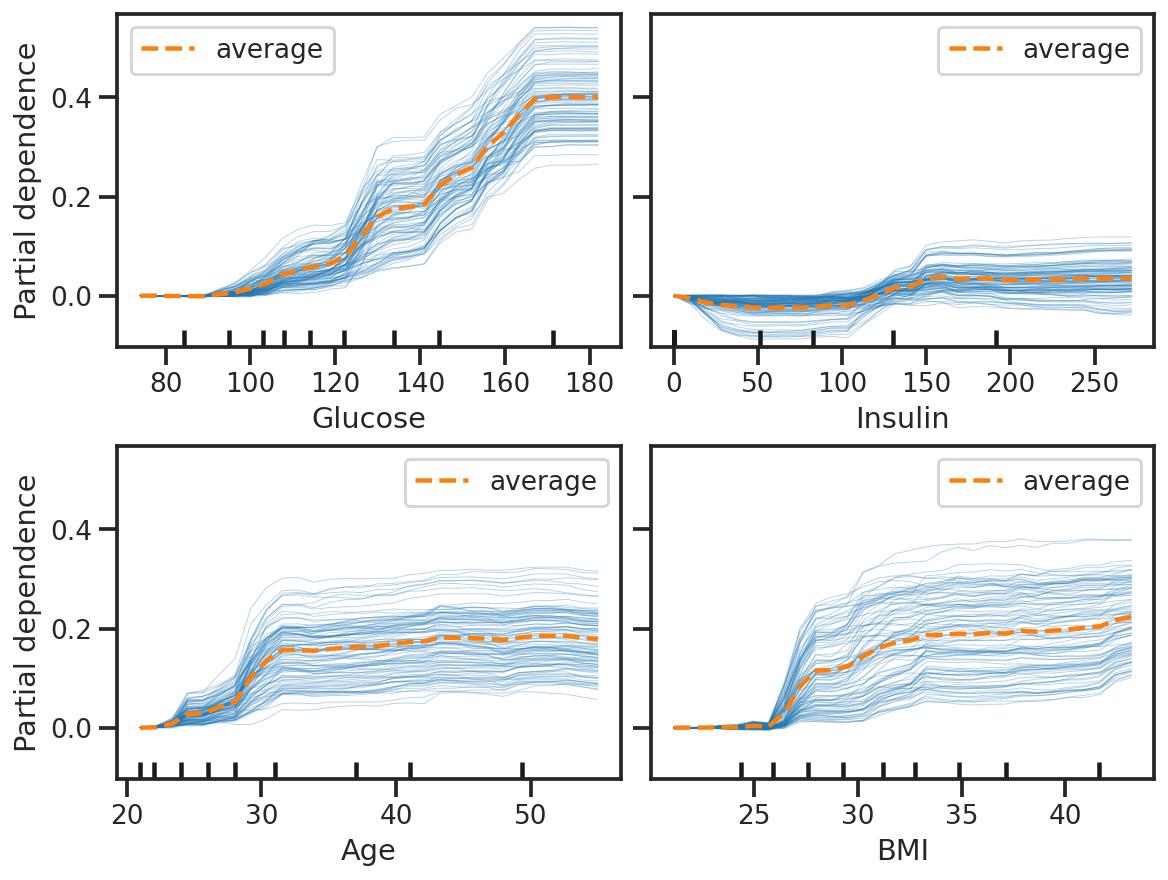

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    clf_pipe, X_test, features=['Glucose', 'Insulin', 'Age', 'BMI'],
    kind='both', centered=True,
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

In [ ]:
# you can also bypass the pre-defined plots and work with ICE/PDP data directly...
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html

In [ ]:
# Your homework: AMES/Regression?